# Генератор отзывов

## Импорт библиотек

In [ ]:
import wget

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

## EDA

### Загрузка датасета

In [2]:
url = 'https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv'
filename = wget.download(url)

### Преобразование в датафрейм

In [123]:
# Считаем при помощи pandas исходный файл с табуляцией в качестве разделителя, задав нужные нам имена колонок
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [124]:
# Посмотрим первые строки
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


### Базовый анализ датафрейма

Посмотрим основную информацию по нашему датафрейму

In [4]:
# Размер датафрейма
print(f'Размер датафрейма: {df.shape}')

Размер датафрейма: (500000, 5)


In [5]:
# Типы данных
print(df.dtypes)

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object


In [6]:
# Кол-во уникальных значений
df.nunique()

address    191925
name_ru    148461
rating        393
rubrics     32694
text       498918
dtype: int64

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Видим, что в колонке 'text' есть пропущенные значения. Поскольку данных у нас очень много, и целиком датасет мы все равно использовать не будем (так как дообучение моделей тогда растянется на несколько недель), просто удалим все строки, где есть пропущенные значения.

In [125]:
df = df.dropna(ignore_index=True)

In [126]:
# Проверим наличие дубликатов
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

np.int64(1)

In [127]:
df.loc[df.duplicated(keep=False), :]

,address,name_ru,rating,rubrics,text
123882,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."
123884,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."


Действительно, у нас есть один дубликат

In [128]:
# Теперь обрежем точку после цифры в колонке 'rating' и приведем колонку к типу int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\User\AppData\Local\Temp\ipykernel_12192\3031245841.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['rating'] = df['rating'].replace('\.', '', regex=True)


Посмотрим, как в датасете распределены оценки

<Axes: xlabel='rating', ylabel='Count'>

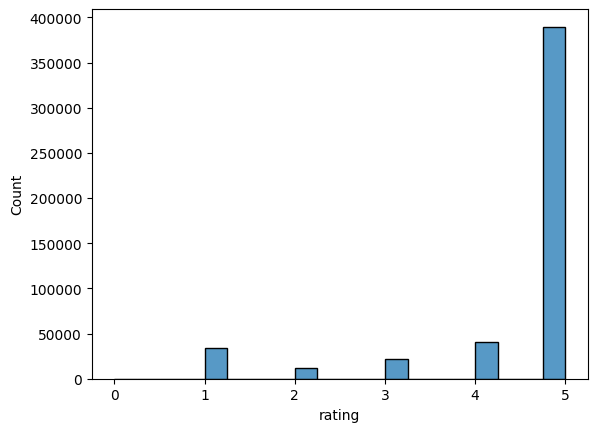

In [129]:
sns.histplot(df['rating'])

In [13]:
# Посмотрим, что из себя представляют отзывы на 0 баллов
df.query('rating == 0').head()

,address,name_ru,rating,rubrics,text
1906,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2164,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3583,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3614,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6384,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."


Как мы видим, отзывы на 5 звезд люди оставляют значительно чаще, чем с другим рейтингом. Наверное, в дальнейшем нам стоит сбалансировать классы для обучающей выборки.
Так же есть шум в виде отзывов на 0 баллов (хотя если посмотреть на текст таких отзывов - он в основном положительный).

Добавим в наш датафрейм колонку, в которой будет указана длина отзыва и проанализируем полученный результат.

In [130]:
df['review_length'] = df['text'].str.len()

In [131]:
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

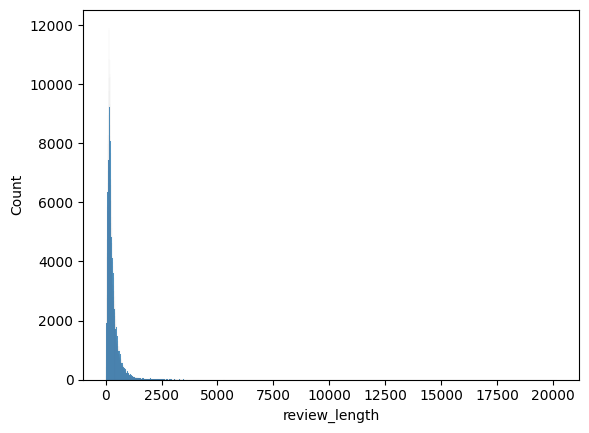

In [132]:
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

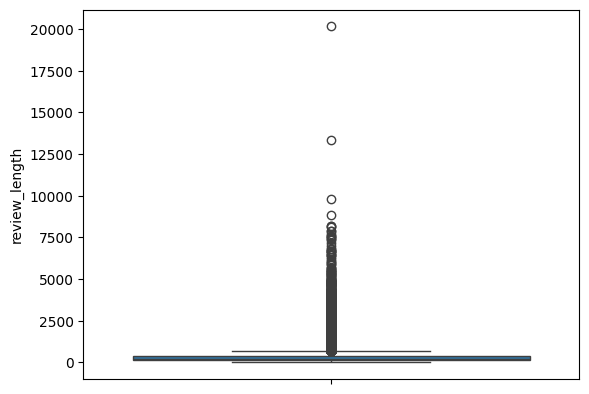

In [17]:
sns.boxplot(df['review_length'])

In [90]:
# Посмотрим, как выглядят отзывы более 10000 символов
df.query('review_length > 10000')['text'].values

array(['Que si, que no...\\nМногажды бывал в этом замечательном отеле, и с каждым разом всё больше и больше эта песня про тупящего влюблённого, являющаяся гимном отеля, всё точнее и точнее описывает качество отдыха. Вообще, этот гимн противоречиям максимально отражает происходящее с Вами на отдыхе в Ялта Интурист.\\nНачинается знакомство с особенностями сервиса со службы размещения (это те, кого называют ресепшн). Приветливость сотрудников на стойке регистрации можно выделить отдельно, Вас всегда встретят с улыбкой, всё расскажут и ответят на Ваши вопросы при заселении, но на чемпионате мира по созданию очередей, они без особого труда возьмут второе место (первое – без шансов конкурентам у транспортной безопасности терминала Аэроэкспресс в Шереметьево). Специальный удобный трансфер быстро перемещает десятки гостей из аэропорта и вокзала в очередь на заселение, где на 6 стойках регистрации работают всего один или два сотрудника. Господа, это, же, элементарно: на время прибытия трансферо

In [91]:
# И также как выглядят отзывы менее 10 символов
df.query('review_length < 10')['text'].values

array(['Круто', 'Круто', 'кайф\\n', 'Все круто', 'Отлично ', 'Отлично!',
       'Прилично ', 'Лучшие!', 'Клас!', 'Класс', 'Хорошо ', 'Удобно',
       'Супер', 'Не плохо ', 'Нормально', 'Спасибо!', 'Отлично',
       'Спасибо', 'Норм', 'Стандарт.', 'Чисто!', 'Все отл', 'Удобно',
       'Хорошо', '10 из 10', 'Ок', 'Вкусно', 'Супер', 'Норм', 'Вкусно',
       'Красавцы', 'Не вкусно', 'Все норм.', 'Профи!', 'Отлично.',
       'Круть', 'Чисто', 'Отлично.', 'Хорошо ', 'Бомба', 'Всё супер',
       'топ топ', 'Норм', 'Вполне!', 'Всё чëтко', 'Вкусно', 'Класс! '],
      dtype=object)

Как видим, у нас присутствуют выбросы (как слишком маленькая длина отзыва, так и слишком большая).
В обоих вариантах отзывы лишены здравого смысла.
В дальнейшем нужно будет удалить эти выбросы из датафрейма.

In [133]:
df_cor = df[['rating', 'review_length']]
df_cor

,rating,review_length
0,3,537
1,5,158
2,1,485
3,4,142
4,5,373
...,...,...
499025,5,76
499026,4,295
499027,4,325
499028,5,502


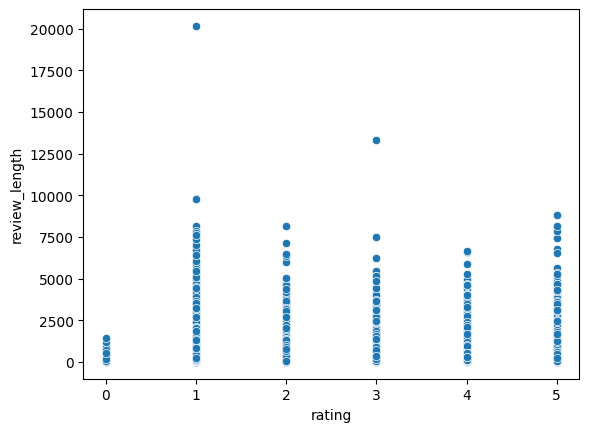

In [134]:
# Диаграмма рассеяния
sns.scatterplot(x='rating', y='review_length', data=df_cor)
plt.show()

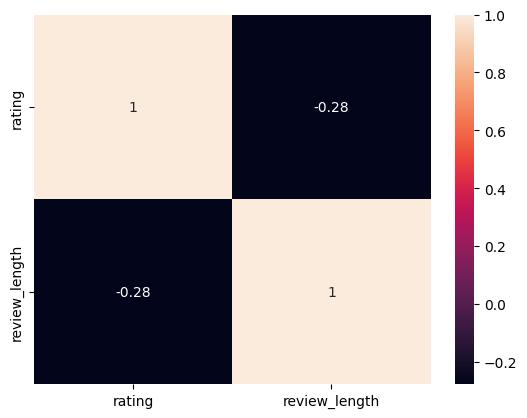

In [22]:
# Корреляционная матрица
corr_matrix = df_cor.corr()

# Визуализируем корреляционную матрицу
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
# Сохраним наш датафрейм в tsv файл для дальнейшей работы
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

### Расчет частотности слов

Теперь посчитаем количество уникальных слов в отзывах

In [ ]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [ ]:
# Удалим из строки все спец.символы
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0«»\t—…n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# Приведем все слова к нижнему регистру
text = text.lower()

In [ ]:
# Токенизируем текст
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [ ]:
# Посмотрим статистику по неочищенным словам


# Для применения инструментов частотного анализа библиотеки NLTK необходимо список токенов преобразовать к классу Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

print('Статистика по неочищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по неочищенным словам

Всего слов: 21306636

Уникальных слов: 742932

Топ-10 слов по частоте: 
и:  874480
в:  604858
не:  400240
на:  389339
очень:  298972
с:  289708
что:  205890
все:  170685
но:  141965
по:  137147


In [ ]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

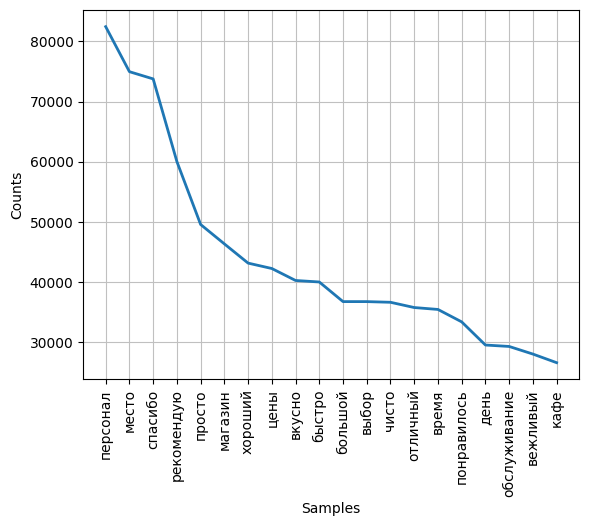

In [ ]:
# Чтобы добавить сюда что-нибудь красивое - нарисуем график частоты топ-20 очищенных слов

fdist.plot(20,cumulative=False)

### Облако слов

Составим облако очищенных слов по частоте употребления

In [ ]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

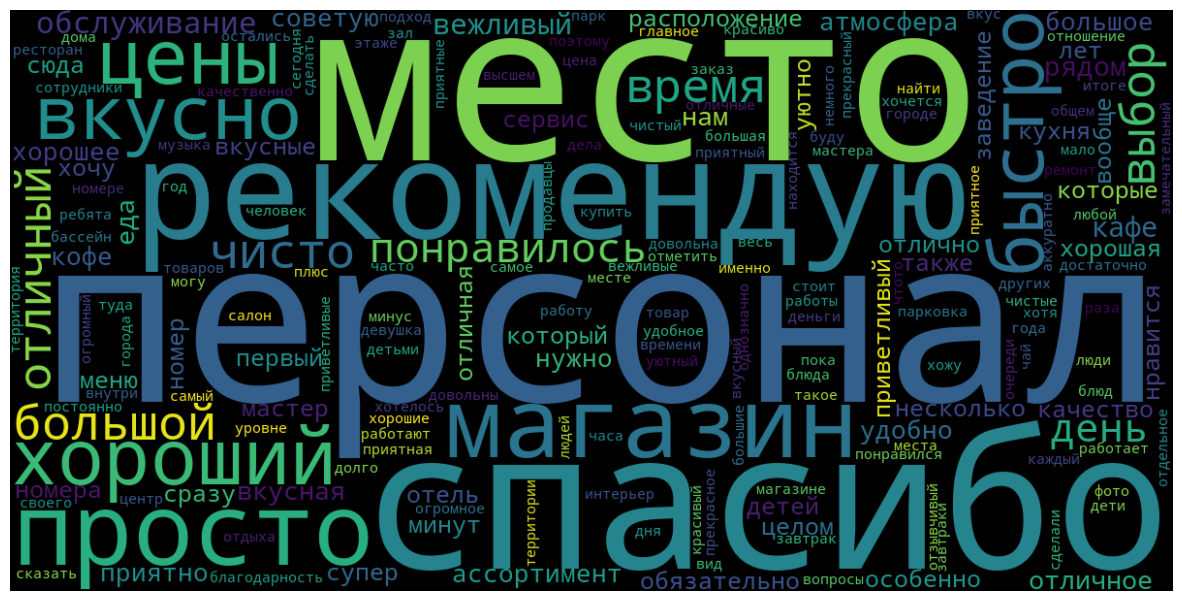

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Выводы по этапу EDA:
1. Нужно удалить строки с пропущенными значениями
2. Нужно удалить дубликаты
3. Нужно удалить строки с отзывами на 0 баллов
4. Нужно удалить строки со слишком большой и слишком маленькой длиной текста отзыва
5. Возможно, для дальнейшего обучения моделей стоит сбалансировать классы отзывов по значениям рейтига 

## Предобработка

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499030 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        499030 non-null  object
 1   name_ru        499030 non-null  object
 2   rating         499030 non-null  int64 
 3   rubrics        499030 non-null  object
 4   text           499030 non-null  object
 5   review_length  499030 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


Строки с пропущенными значениями и дубликаты были удалены на прошлых этапах

Нормализация текстов (удаление спецсимволов, приведение к нижнему регистру):

In [136]:
def normalize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    
    return text

# Применяем функцию ко всем отзывам
df['text'] = df['text'].apply(normalize_text)


Обработка категорий (rubrics):

In [137]:
df.nunique()

address          191639
name_ru          148456
rating                6
rubrics           31724
text             498805
review_length      3004
dtype: int64

In [96]:
# Cгруппировать все категории, которые встречаются менее чем в 0.00021% случаев
category_counts = df['rubrics'].value_counts(normalize=True)
rare_categories = category_counts[category_counts < 0.0000021].index

rare_categories

Index(['Школа танцев;Студия йоги;Стретчинг',
       'Магазин подарков и сувениров;Музыкальный магазин',
       'Алкогольная продукция оптом;Пивоварня, пивоваренный завод;Магазин пива',
       'Магазин электротоваров;Электротехническая продукция;Товары для дома;Магазин хозтоваров и бытовой химии;Замки и запорные устройства;Магазин бытовой техники;Садовый инвентарь и техника',
       'Керамическая плитка;Изделия из камня;Облицовочные материалы',
       'Доставка еды и обедов;Пекарня;Быстрое питание;Кафе;Кофейня;Торты на заказ',
       'Товары для интерьера;Художественный салон;Широкоформатная печать',
       'Нерудные материалы;Строительство и ремонт дорог;Аренда строительной и спецтехники',
       'Садовый центр;Строительный магазин;Магазин хозтоваров и бытовой химии',
       'Салон красоты;Магазин парфюмерии и косметики;Салон бровей и ресниц',
       ...
       'Стоматологическая клиника;Гинекологическая клиника;Косметология',
       'Электронные приборы и компоненты;IT-компания',
    

In [52]:
# Объединяем редкие категории в одну
#df['rubrics'] = df['rubrics'].replace(rare_categories, 'Прочие')

Удаляем строки с рейтингом 0

In [138]:
# Убираем строки с рейтингом 0
filtered_df = df.query("rating > 0")

filtered_df.nunique()


address          191595
name_ru          148421
rating                5
rubrics           31715
text             498606
review_length      3004
dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

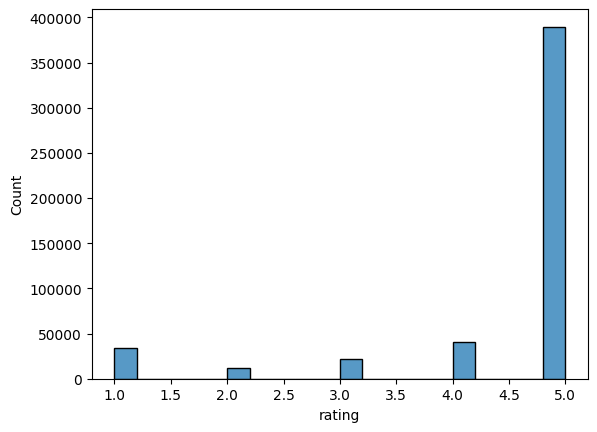

In [139]:
sns.histplot(filtered_df['rating'])


In [140]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498830 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498830 non-null  object
 1   name_ru        498830 non-null  object
 2   rating         498830 non-null  int64 
 3   rubrics        498830 non-null  object
 4   text           498830 non-null  object
 5   review_length  498830 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось 200 строк

Удаляем строки со слишком большой и слишком маленькой длиной текста отзыва

In [141]:
filtered_df = filtered_df.query('review_length < 4000')

filtered_df = filtered_df.query('review_length > 10')

In [142]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось еще 191 строка

<Axes: xlabel='review_length', ylabel='Count'>

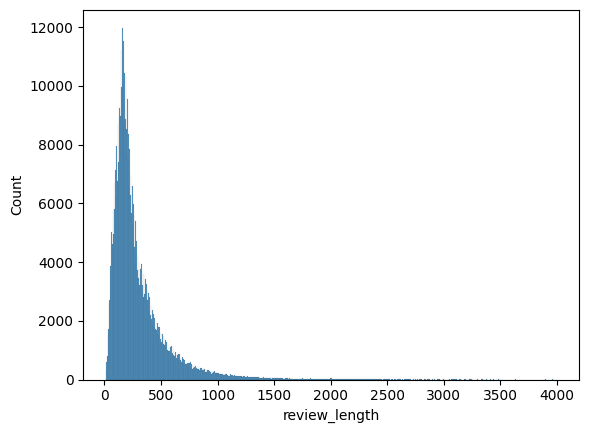

In [143]:
sns.histplot(filtered_df['review_length'])

In [144]:
print(Counter(filtered_df['rating']))

Counter({5: 389606, 4: 41096, 1: 34246, 3: 21634, 2: 12057})


Заменяем символы переноса строки (\\n) на пробелы:

In [153]:
work_data = filtered_df


In [151]:
work_data['text'] = work_data['text'].str.replace('\\n', ' ')

In [152]:
work_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


## Обучение

## Совершенствование

## Анализ

## Итог

In [ ]:
print('try me my mad')